In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
node_type = 'compute_haswell'
interval = 24

# Step 1. Preprocess Machine Events

In [3]:
ucme = pd.read_csv('datasets/uc_machine_events.csv')
taccme = pd.read_csv('datasets/tacc_machine_events.csv')
ucme['EVENT_TIME'] = pd.to_datetime(ucme['EVENT_TIME'])
taccme['EVENT_TIME'] = pd.to_datetime(taccme['EVENT_TIME'])
ucme.sort_values(by=['EVENT_TIME'], inplace=True)
taccme.sort_values(by=['EVENT_TIME'], inplace=True)

In [4]:
def set_machine_type(df):
    node_types = []
    for index, row in df.iterrows():
        try:
            nt = row['PROPERTIES']
            nt = nt.replace('\'', '\"')
            nt = nt.replace('None', '\"None\"')
            if 'node_type' in nt:
                nt = json.loads(nt)['node_type']
            else:
                nt = None
        except:
            nt = None
        node_types.append(nt)
    df['node_type'] = node_types
    return df

ucme = set_machine_type(ucme)
taccme = set_machine_type(taccme)

In [5]:
# select haswell only
ucme = ucme[ucme['node_type']==node_type]
taccme = taccme[taccme['node_type']==node_type]

In [6]:
ucme_start_date = ucme.iloc[0]['EVENT_TIME']
ucme_end_date = ucme.iloc[-1]['EVENT_TIME']
taccme_start_date = taccme.iloc[0]['EVENT_TIME']
taccme_end_date = taccme.iloc[-1]['EVENT_TIME']

# Step 2. Preprocess Lease Info Data

In [7]:
litacc = pd.read_csv('datasets/lease_info_tacc.csv')
liuc = pd.read_csv('datasets/lease_info_uc.csv')

In [8]:
def process_lease_data(df):
    # df = df[~df['status'].isin(['error', 'deleted'])]
    df['start_on'] = pd.to_datetime(df['start_on'])
    df['deleted_at'] = pd.to_datetime(df['deleted_at'])
    df['end_on'] = pd.to_datetime(df['end_on'])
    for index, row in df.iterrows():
        if row['deleted_at'] > row['end_on']:
            row['deleted_at'] = row['end_on']
    df.sort_values(by=['start_on'], inplace=True)
    return df
    
litacc = process_lease_data(litacc)
liuc = process_lease_data(liuc)
filter_by_date = lambda df, start, end: df[(df['start_on'] >= start) & (df['start_on'] <= end)] 
litacc = filter_by_date(litacc, taccme_start_date, taccme_end_date)
liuc = filter_by_date(liuc, ucme_start_date, ucme_end_date)

In [9]:
from ast import literal_eval

def filter_node_type(df):
    node_types = list(set([literal_eval(nt)[2] for nt in df['reserve_conditions'].dropna() if '$node_type' in literal_eval(nt)]))
    assign_nt = []
    select_leases = []
    for index, row in df.iterrows():
        if row['reserve_conditions'] is not np.nan:
            if '$node_type' in literal_eval(row['reserve_conditions']):
                assign_nt.append(literal_eval(row['reserve_conditions'])[2])
                select_leases.append(row['lease_id'])
    df = df[df['lease_id'].isin(select_leases)]
    df['node_type'] = assign_nt
    df = df[df['node_type'] == node_type]
    return df

litacc = filter_node_type(litacc)
liuc = filter_node_type(liuc)
litacc.sort_values(by=['start_on'], inplace=True)
liuc.sort_values(by=['start_on'], inplace=True)

# Step 3. Trace In-use and Available Resources

In [10]:
def trace_in_use(df, slot):
    date_time = [None]
    node_count = [0]
    for index, row in df.iterrows():
        date_time.append(row['start_on'])
        node_count.append(node_count[-1]+row['node_cnt'])
        date_time.append(row['deleted_at'])
        node_count.append(node_count[-1]-row['node_cnt'])

    tracer = pd.DataFrame([])
    tracer['timestamp'] = date_time[1:]
    tracer['in_use'] = node_count[1:]
    tracer.sort_values(by=['timestamp'], inplace=True)
    tracer.set_index(['timestamp'], inplace=True)
    tracer = tracer.resample('%dH' % slot).max().fillna(0)
    return tracer

litacc_tracer = trace_in_use(litacc, interval)
liuc_tracer = trace_in_use(liuc, interval)

In [11]:
def trace_av(df, slot):
    date_time = [None]
    node_count = [0]
    unique_host = {}
    for index, row in df.iterrows():
        if row['EVENT'] in ['ENABLE', 'UPDATE'] and row['HOST_NAME (PHYSICAL)'] not in unique_host:
            unique_host.update({row['HOST_NAME (PHYSICAL)']: row['EVENT']})
            date_time.append(row['EVENT_TIME'])
            node_count.append(node_count[-1]+1)
        elif row['EVENT'] == 'DISABLE' and row['HOST_NAME (PHYSICAL)'] in unique_host:
            del unique_host[row['HOST_NAME (PHYSICAL)']]
            date_time.append(row['EVENT_TIME'])
            node_count.append(node_count[-1]-1)

    tracer = pd.DataFrame([])
    tracer['timestamp'] = date_time[1:]
    tracer['available'] = node_count[1:]
    tracer.sort_values(by=['timestamp'], inplace=True)
    tracer.set_index(['timestamp'], inplace=True)
    tracer = tracer.resample('%dH' % slot).max().fillna(method='ffill')
    return tracer

taccme_tracer = trace_av(taccme, interval)
ucme_tracer = trace_av(ucme, interval)

In [12]:
tacc_tracer = taccme_tracer.join(litacc_tracer)
uc_tracer = ucme_tracer.join(liuc_tracer)

In [13]:
def plot_trace(data, fields):
    fig = go.Figure()
    for f in fields:
        fig.add_trace(go.Scatter(x=data.index, y=data[f], mode='lines', name=f))
    fig.update_layout(showlegend=True)

    fig.update_layout(
        width=1000,
        height=500,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [14]:
plot_trace(tacc_tracer, ['available', 'in_use'])

In [15]:
plot_trace(uc_tracer, ['available', 'in_use'])

In [16]:
tacc_tracer['rate'] = tacc_tracer['in_use']/tacc_tracer['available']
uc_tracer['rate'] = uc_tracer['in_use']/uc_tracer['available']

In [17]:
tacc_tracer['rate'].quantile([.1, .2, .3, .5, .7, .9, .95, .99])

0.10    0.009756
0.20    0.014286
0.30    0.019048
0.50    0.030864
0.70    0.053659
0.90    0.146341
0.95    0.228554
0.99    0.409456
Name: rate, dtype: float64

In [18]:
uc_tracer['rate'].quantile([.1, .2, .3, .5, .7, .9, .95, .99])

0.10    0.019414
0.20    0.024691
0.30    0.024691
0.50    0.025000
0.70    0.060976
0.90    0.151899
0.95    0.250000
0.99    0.579378
Name: rate, dtype: float64

<AxesSubplot:>

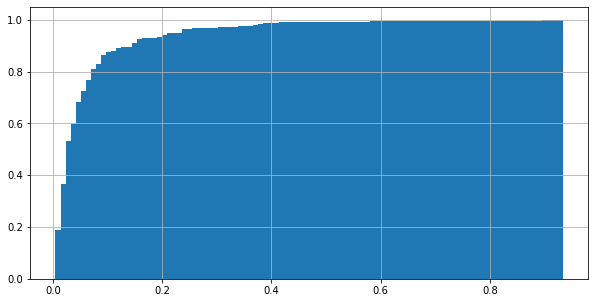

In [19]:
tacc_tracer['rate'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))

<AxesSubplot:>

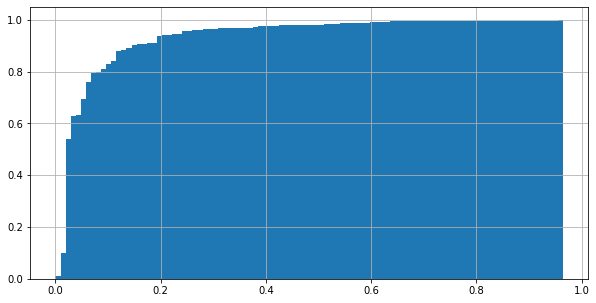

In [20]:
uc_tracer['rate'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))